<a href="https://colab.research.google.com/github/NicolaGabriele/powerline_Segmentation_project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IMPORT DELLE LIBRERIE E CARICAMENTO DEL DATASET**


In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import random
from pycocotools import mask
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
TRAIN_DIR = '/content/drive/MyDrive/trainingset' #'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\trainingset'#
TEST_DIR = '/content/drive/MyDrive/testset' #'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\testset'#
TRAIN_LABELS = '/content/drive/MyDrive/train.json' #'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\train.json'#
TEST_LABELS =  '/content/drive/MyDrive/test.json' #'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\test.json'
IM_WIDTH = 700
IM_HEIGHT = 700

In [3]:
def groupByImageId(jsonfile):
  data = jsonfile['annotations']
  labs = {}
  for k in data:
    if k['image_id'] in labs:
      labs[k['image_id']].append(k)
    else:
      labs[k['image_id']] = [k]
  return labs

In [87]:
def formatLabels(labels):
  bbox = torch.zeros([len(labels),4], dtype=torch.float32)
  seg = []
  cls = []
  i = 0
  for label in labels:
    seg.append(decodeSegmentationField(label['segmentation']))
    b = label['bbox']
    box = [b[0],b[1],b[0]+b[2], b[1]+b[3]]
    bbox[i] = torch.Tensor(box)
    i+=1
    cls.append(label['category_id'])
  return {
      'id': label['id'],
      'masks':torch.Tensor(seg),
      'labels':torch.tensor(cls, dtype = torch.int64),
      'boxes':bbox
  }

In [95]:
class PowerLineDataset(torch.utils.data.Dataset):
  def __init__(self,img_dir,img_labels):
    self.img_dir = img_dir
    self.img_labels = json.load(open(img_labels))
    self.categories = [] #lista delle etichette di classe
    for c in self.img_labels['categories']:
      self.categories.append(c['name'])

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.img_labels['images'][idx]['file_name'])
    label = groupByImageId(self.img_labels)[idx]
    image = (torchvision.io.read_image(img_path)/255)
    tra = torchvision.transforms.Resize((700,700))
    return image,formatLabels(label)
  def __len__(self):
    return len(os.listdir(self.img_dir))

In [96]:
#caricamento dei dataset di train e di test
trainset = PowerLineDataset(TRAIN_DIR, TRAIN_LABELS)
test = PowerLineDataset(TEST_DIR, TEST_LABELS)

#**OPERAZIONI SUI DATI: DATA AUGMENTATION**

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self, in_channels=3):
    super(AutoEncoder,self).__init__()
    self.encoder = nn.Sequential(
         nn.Conv2d(in_channels, 64, kernel_size=3, padding = 1),
         nn.ReLU(),
         nn.Conv2d(64, 128, kernel_size=3, padding = 1),
         nn.ReLU(),
         nn.Conv2d(128, 256, kernel_size=3, padding = 1),
         nn.ReLU(),
         nn.MaxPool2d(2,stride = 2,return_indices=False))
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 128, kernel_size=3, stride = 2, padding = 1, output_padding = 1),
        nn.ReLU(),
        nn.Conv2d(128, 64, kernel_size=3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(64, in_channels, kernel_size=3, padding = 1),
        nn.ReLU())

  def forward(self,x):
    #x.to('cuda')
    x = self.encoder(x)
    x = self.decoder(x)
    return x



In [ ]:
model = AutoEncoder()
#model.to('cuda')

In [97]:
#questo metodo è preso dai notebook e va adattato al caso specifico (loss ecc...)
#costruisco un sottodataset di 200 immagini
#indexs = list(range(0,200))
#trains = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset,indexs), batch_size=64, shuffle=True)
trains = torch.utils.data.DataLoader(trainset)
criterion = torch.nn.MSELoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_step = len(trains)
batch_size = 64

num_epochs = 1

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trains) for i in range(num_epochs + 1)]


def train(epoch,model,criterion,optimizer,reshape=False):
    for batch_idx, (images, labels) in enumerate(trains):
        # Move tensors to the configured device
        #if reshape:
         #   images = images.reshape(-1, 28*28)
        #images = images.to('cuda')
        #labels = labels.to('cuda')
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if random.random() < 0.1:
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, num_epochs, batch_idx+1, total_step, loss.item()))
        if (batch_idx+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, num_epochs, batch_idx+1, total_step, loss.item()))

        train_losses.append(loss.item())
        train_counter.append(
        (batch_idx*batch_size) + ((epoch-1)*len(trains)))

In [ ]:
model = torch.load('/content/drive/MyDrive/autoencoder')
#train(num_epochs,model,criterion, optimizer, reshape=False)

In [ ]:
torch.save(model,'autoencoder')

#**LOSS FUNCTIONS**

In [6]:
def decodeSegmentationField(segmentation):
  return mask.decode(mask.merge(mask.frPyObjects(segmentation,IM_WIDTH,IM_HEIGHT)))

In [8]:
class CustomLossFunction(nn.Module):
  def __init__(self, cls_loss, bb_loss, seg_loss, cls_weight, bb_weight, seg_weight):
    super(CustomLossFunction, self).__init__()
    self.cls_loss = cls_loss
    self.bb_loss = bb_loss
    self.seg_loss = seg_loss
    self.cls_weight = cls_weight
    self.bb_weight = bb_weight
    self.seg_weight = seg_weight
  def forward(self,predictions, targets):
    prediction = predictions[0]
    formatted_targets = formatLabels(targets)
    #loss di classificazione
    #scores di classificazione: uno per ogni oggetto predetto
    targets_cls = formatted_targets['labels']
    pred_cls = prediction['scores']
    loss_cls = self.cls_loss(pred_cls,targets_cls)
    #loss di bbox
    targets_bbox = formatted_targets['boxes']
    pred_bbox = prediction['boxes']
    loss_bbox = self.bb_loss(pred_bbox,targets_bbox)
    #loss per le maschere: sigmoide su tutti i pixel e poi cross entropy
    targets_masks = formatted_targets['masks']
    pred_masks = prediction['masks']
    loss_masks = self.seg_loss(pred_masks,targets_masks)

    return self.cls_weight*loss_cls + self.bb_weight*loss_bbox + self.seg_weight*loss_masks

#**TEST DI UN MODELLO PREADDESTRATO: MASK R-CNN**

In [45]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

In [72]:
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the numbner of output channels for the Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=4)

# Replace the mask predictor
#model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=4)

In [98]:
model.train()
#predictions = model([trainset[3][0]], [formatLabels(trainset[3][1])])
learning_rate = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
batch_size = 64
trains = torch.utils.data.DataLoader(trainset, batch_size = batch_size)
total_step = len(trains)

num_epochs = 1

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trains) for i in range(num_epochs + 1)]


def train(epoch,model,optimizer):
    for batch_idx, (images, targets) in enumerate(trains):
        # Move tensors to the configured device
        #if reshape:
         #   images = images.reshape(-1, 28*28)
        #images = images.to('cuda')
        #labels = labels.to('cuda')
        # Forward pass
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        #backward pass
        losses.backward()
        optimizer.step()

        if (batch_idx+1) % 1 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, num_epochs, batch_idx+1, total_step, losses))

        train_losses.append(losses)
        train_counter.append(
        (batch_idx*batch_size) + ((epoch-1)*len(trains)))

In [91]:
train(epoch=1, model = model, optimizer = optimizer)

RuntimeError: ignored

In [99]:
for batch_idx, (images, targets) in enumerate(trains):
  print(images.shape, targets)

KeyboardInterrupt: ignored

#***CODICI DI PROVA***

In [75]:
model.eval()
im = torchvision.transforms.ToPILImage(trainset[1][0])
prediction = model([trainset[1][0]])

[{'boxes': tensor([[6.7832e+02, 4.4863e+02, 6.9770e+02, 5.7516e+02],
          [1.7900e+02, 0.0000e+00, 6.1855e+02, 1.4209e+02],
          [4.9109e+02, 4.2828e+02, 6.6527e+02, 7.0000e+02],
          [6.5687e+02, 2.7116e+02, 6.9216e+02, 3.0366e+02],
          [0.0000e+00, 5.4272e+02, 5.6832e+02, 6.8735e+02],
          [2.6985e+02, 1.0227e+02, 6.1247e+02, 3.1326e+02],
          [6.7738e+02, 1.7943e+02, 6.9956e+02, 2.7770e+02],
          [5.5299e+02, 3.2092e+02, 6.7015e+02, 4.1191e+02],
          [2.3193e+02, 0.0000e+00, 3.6615e+02, 1.0602e+02],
          [5.8813e+02, 3.5695e+02, 6.0048e+02, 3.7983e+02],
          [6.3307e+02, 2.6807e+02, 6.6644e+02, 3.1631e+02],
          [6.8249e+02, 2.0678e+02, 6.9988e+02, 2.5700e+02],
          [5.0072e+02, 1.2664e+02, 6.5739e+02, 2.0779e+02],
          [6.5577e+02, 1.1485e+02, 6.9746e+02, 3.6200e+02],
          [3.5483e+02, 1.3221e+02, 3.8185e+02, 1.6319e+02],
          [1.8266e+02, 0.0000e+00, 2.9611e+02, 1.1434e+02],
          [6.5657e+02, 2.3536e+

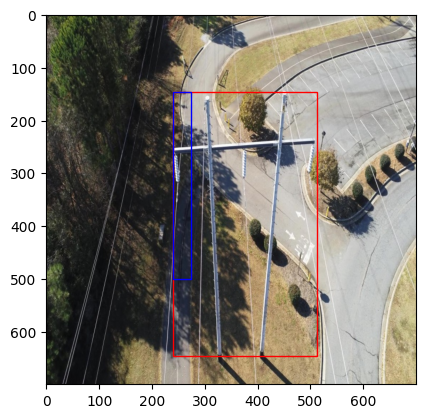

In [74]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = torchvision.transforms.ToPILImage()(trainset[1][0])

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)
#239.0, 145.0, 273.0, 500.0
# Create a Rectangle patch
rect = patches.Rectangle((239, 145), 273, 500, linewidth=1, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((239, 145), 273-239, 500-145, linewidth=1, edgecolor='b', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
ax.add_patch(rect2)

plt.show()

In [36]:
formatLabels(trainset[1][1])

{'id': 18,
 'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0.